In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



In [3]:
df=pd.read_csv('HPE_Webinars.csv')
df.head()

,Category,Webinar_Title
0,Services,hpe greenlake for vdi
1,Networking,aruba ap-505 (rw) taa dual radio 2x2:2 802.11a...
2,Storage,hpe primera 600: upgrading a node pair
3,Storage,transforming hypervisors into deduplication ba...
4,Hybrid Cloud,b514 avoiding common mistakes in the cloud: be...


In [4]:
#Exploratory Data we want to know how the data is distributed for the Category attribute
df.groupby('Category').agg(['count'])

,Webinar_Title
,count
Category,
Compute,1721
Hybrid Cloud,719
Networking,1663
Services,289
Software,189
Solutions,327
Storage,1997


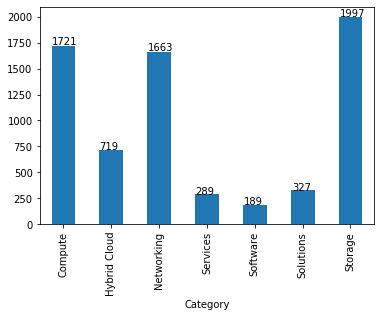

In [5]:
ax=df.groupby('Category')['Category'].count().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

In [6]:
#we learned that this is an imbalanced dataset, we will down sample the categories to match the lowest category with random examples for each categories. 
webinar_balanced=df.groupby('Category', group_keys=False).apply(lambda x: x.sample(min(len(x), 189)))


In [7]:
#let's look at the new balanced Data Frame:
print(webinar_balanced.shape)
webinar_balanced.groupby('Category').agg(['count'])

(1323, 2)


,Webinar_Title
,count
Category,
Compute,189
Hybrid Cloud,189
Networking,189
Services,189
Software,189
Solutions,189
Storage,189


In [8]:
#let’s Begin with Text Vectorization, this will create the Vectors that the algorithms will use as input 
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(webinar_balanced.Webinar_Title).toarray()
labels = webinar_balanced.Category
features.shape

(1323, 611)

In [9]:
#Now It is time to split the data in Training and Test subsets

X_train, X_test, y_train, y_test = train_test_split(webinar_balanced['Webinar_Title'], webinar_balanced['Category'], random_state = 0)
count_vect = CountVectorizer()



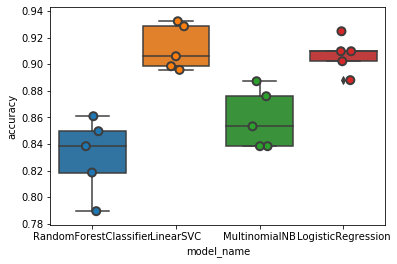

In [10]:
# we will evaluate 4 algorithms to compare the accuracy using the Cross Validation Method and plotting the results for visual comparison
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [11]:
#Let's review the average accuracy of each algorithm
cv_df.groupby('model_name').accuracy.mean()



model_name
LinearSVC                 0.912233
LogisticRegression        0.906929
MultinomialNB             0.858626
RandomForestClassifier    0.831376
Name: accuracy, dtype: float64


LinearSVC is the best performing algorithm, now we are ready to fit the model with all the data available before we create the final pipeline that will be moved to production:


In [12]:
model_final=LinearSVC()

In [13]:
model_final.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [14]:
nd=df.loc[:,['Webinar_Title','Category']].sample(50)
nd['Category']=np.nan
nd


,Webinar_Title,Category
4265,hpe simplivity and micro focus data protector,NaN
2238,solution overview - agile stacks,NaN
5937,hpe nimble storage hf20h adaptive dual control...,NaN
3482,hpe reference architecture for digital workspa...,NaN
3017,xl190r gen10 node server,NaN
3549,hpe proliant dl380 gen10 carrier grade server,NaN
2342,hpe compute solutions for remote work,NaN
1158,hpe 6127xlg ethernet blade switch,NaN
3263,hpe simplivity client virtualization planning ...,NaN
5488,hpe 3par os 3.2.2 mu4 patch 164 release notes,NaN


In [15]:
# new instances where we do not know the answer
Xnew =  nd['Webinar_Title'].apply(lambda x: np.str_(x))
#make a prediction
pred = model_final.predict(tfidf.transform(Xnew))
predicted=list(zip(Xnew,pred))


In [16]:
nd['Category']=pred

In [17]:
nd.head(25)

,Webinar_Title,Category
4265,hpe simplivity and micro focus data protector,Compute
2238,solution overview - agile stacks,Solutions
5937,hpe nimble storage hf20h adaptive dual control...,Storage
3482,hpe reference architecture for digital workspa...,Storage
3017,xl190r gen10 node server,Compute
3549,hpe proliant dl380 gen10 carrier grade server,Compute
2342,hpe compute solutions for remote work,Solutions
1158,hpe 6127xlg ethernet blade switch,Networking
3263,hpe simplivity client virtualization planning ...,Compute
5488,hpe 3par os 3.2.2 mu4 patch 164 release notes,Storage
